# CALIDAD DEL AIRE CIUDAD DE DUITAMA

## DATASET
La vertical de calidad de aire de Duitama está compuesta por sensores IoT que realizan las mediciones de diferentes contaminantes ubicados en diferentes puntos de la ciudad, como se enuncia a continuación:

1. Sensor de calidad del aire desarrollado por el Centro Internacional de Física de la Universidad Nacional de Colombia CIF

• Nombres de los dispositivos en el set de datos: AirQualityUnit01, AirQualityUnit02, AQ_SEP
• Variables de medición: Temperatura, Humedad relativa, CO2, CO, PM2.5, PM5, PM10
• Tasa de transmisión: cada 5 min
• Lugares de instalación:
- Antiguo Terminal de transportes de Duitama, Calle 17 # 18-32
- Avenida circunvalar # 16A - 18, Duitama, Boyacá
- Calle 20 # 30-00, Avenida Camillo Torres con carrera 30, Duitama, Boyacá


## ¿Cual es el problema?
* Este proyecto tiene como objetivo desarrollar un modelo que permita estimar los principales contaminantes atmosféricos utilizados para evaluar la calidad del aire, con el fin de optimizar la vigilancia ambiental, reducir costos en sensores físicos y mejorar la identificación de contaminantes críticos.

* Uno de los mayores desafíos es la medición del PM₂.₅, un material particulado ultrafino que, por su pequeño tamaño, puede comportarse como gas, verse afectado por condiciones como la humedad relativa y requerir equipos costosos para su medición. Además, es altamente peligroso para la salud, ya que puede ingresar al sistema respiratorio y alcanzar el torrente sanguíneo, aumentando el riesgo de enfermedades graves.

* El modelo propuesto busca estimar este tipo de contaminantes a partir de variables ambientales más accesibles, como temperatura, humedad o concentraciones de otros compuestos, permitiendo una gestión más eficiente y económica de la calidad del aire.

In [ ]:
# Importacion de librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler

# 1. Importacion de Data

In [ ]:
url = "https://www.datos.gov.co/resource/aghd-ge2f.json"
aire = pd.read_json(url)

In [ ]:
aire.info() # No se presentan datos faltantes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fecha             1000 non-null   object 
 1   nombre_equipo     1000 non-null   object 
 2   co                1000 non-null   int64  
 3   co2               1000 non-null   int64  
 4   pm10              1000 non-null   int64  
 5   pm2_5             1000 non-null   int64  
 6   pm5               1000 non-null   int64  
 7   humedad_relativa  1000 non-null   float64
 8   temperatura       1000 non-null   float64
dtypes: float64(2), int64(5), object(2)
memory usage: 70.4+ KB


### Conclusiones
* No se presentan valores nulos
* La variable fecha no esta propiamente como tipo DateTime. Se debe hacer la conversión de tipo de dato.


In [ ]:
aire.head(5) # Los datos estan de acuerdo a la descripción

,fecha,nombre_equipo,co,co2,pm10,pm2_5,pm5,humedad_relativa,temperatura
0,2023-08-01T00:00:19.000,AirQualityUnit02,2,450,5,4,4,0.0,0.0
1,2023-08-01T00:02:25.000,AirQualityUnit02,3,448,6,6,4,65.4,13.6
2,2023-08-01T00:04:31.000,AirQualityUnit02,4,453,26,22,14,52.7,0.8
3,2023-08-01T00:08:36.000,AirQualityUnit02,6,459,13,10,7,0.0,0.0
4,2023-08-01T00:10:41.000,AirQualityUnit02,7,461,10,9,6,53.0,0.8


In [ ]:
aire["fecha"] = pd.to_datetime(aire['fecha']) # Se convierte la columna fecha (object) - datetime pandas

In [ ]:
# RANGO DE CAPTURA DE DATOS
rango = aire['fecha'].max() - aire['fecha'].min()
print("Duración total:", rango)
print('Fecha inicial: ', aire['fecha'].min(), ' - ', 'Fecha final: ', aire['fecha'].max())

Duración total: 3 days 11:44:43
Fecha inicial:  2023-08-01 00:00:19  -  Fecha final:  2023-08-04 11:45:02


## Conclusiones
* Las mediciones corresponden a aproximadamente 3 dias y medio correspondientes a las fechas de 01 de agosto de 2023 hasta el 4 de agosto de 2023. Estos dias correspondian al dia martes hasta el dia viernes.

## Visualización del comportamiento de los datos de entrada

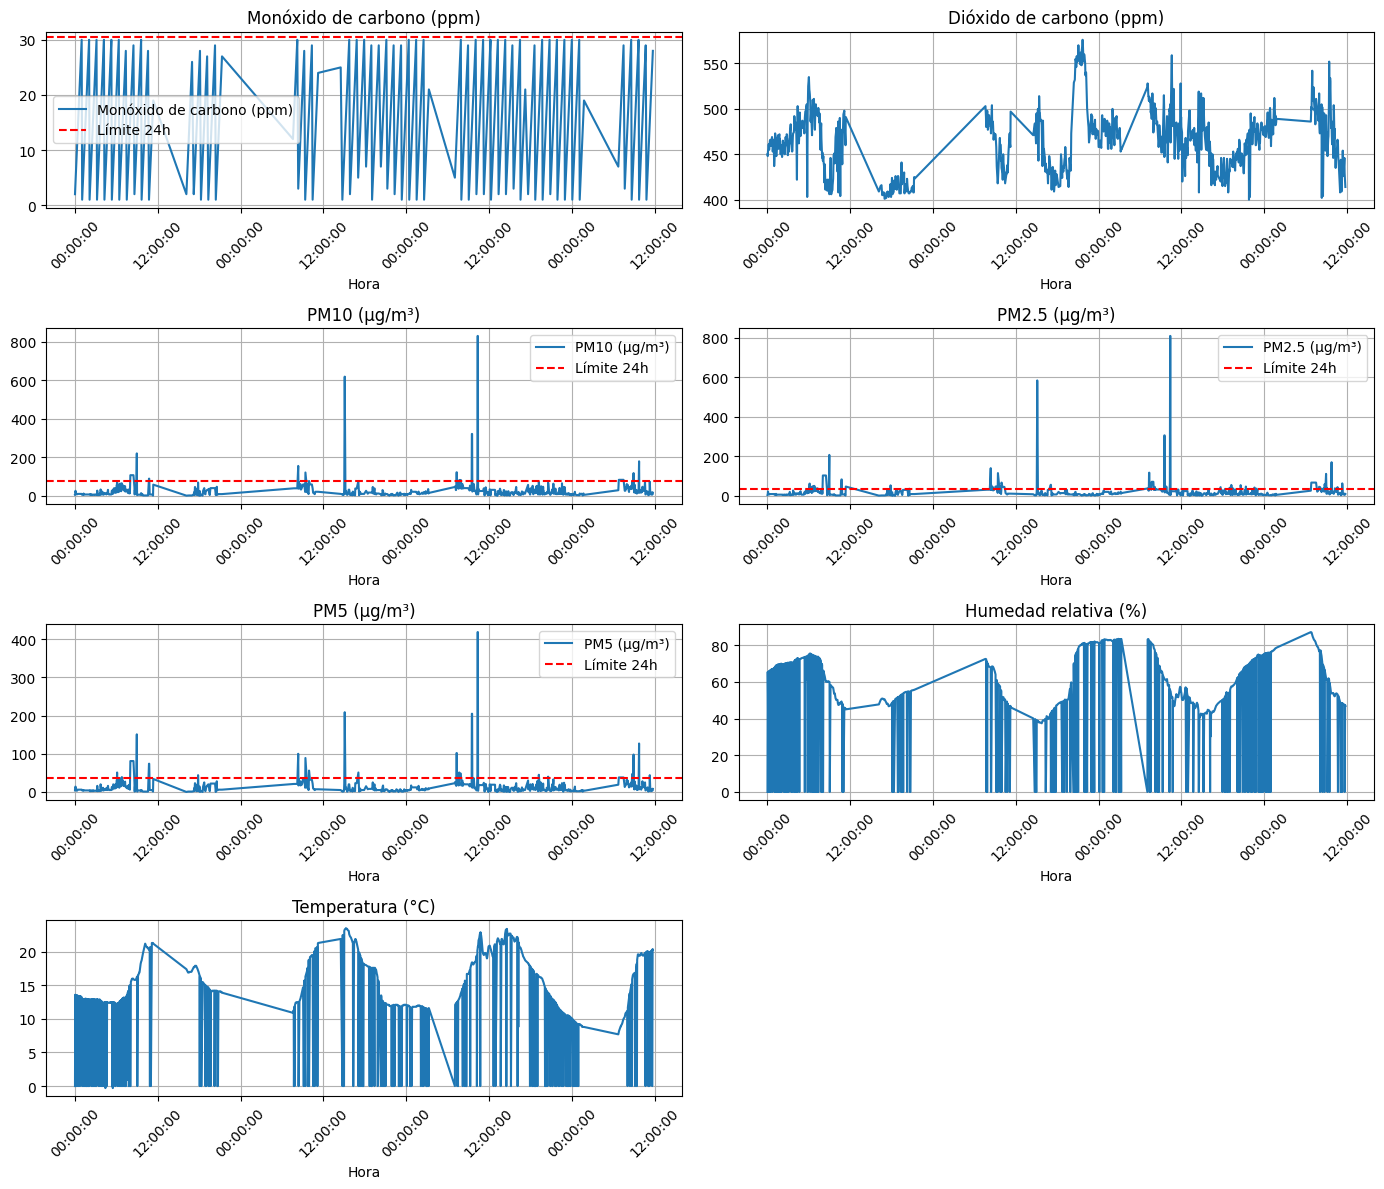

In [ ]:
# Diccionario con los límites máximos permisibles en 24h (según la normativa colombiana)
limites_24h = {
    'pm10': 75,       # µg/m³
    'pm2_5': 37,      # µg/m³
    'pm5': 37,        # usaremos el mismo que para PM2.5
    'co': 30.55,       # 35.000 microgramos/m3 equivale a 30.55 ppm para CO segun formula de gases ideales
    'co2': None
}

fig, axs = plt.subplots(4, 2, figsize=(14, 12))
axs = axs.flatten()

formato_hora = mdates.DateFormatter('%H:%M:%S')

variables = [
    ('co', 'Monóxido de carbono (ppm)'),
    ('co2', 'Dióxido de carbono (ppm)'),
    ('pm10', 'PM10 (µg/m³)'),
    ('pm2_5', 'PM2.5 (µg/m³)'),
    ('pm5', 'PM5 (µg/m³)'),
    ('humedad_relativa', 'Humedad relativa (%)'),
    ('temperatura', 'Temperatura (°C)')
]

for i, (columna, titulo) in enumerate(variables):
    axs[i].plot(aire['fecha'], aire[columna], label=titulo)
    axs[i].set_title(titulo)
    axs[i].xaxis.set_major_formatter(formato_hora)
    axs[i].set_xlabel('Hora')
    axs[i].grid(True)
    axs[i].tick_params(axis='x', rotation=45)

    # Agregar línea punteada roja si hay límite para la variable
    if columna in limites_24h and limites_24h[columna] is not None:
        axs[i].axhline(y=limites_24h[columna], color='red', linestyle='--', linewidth=1.5, label='Límite 24h')
        axs[i].legend()

# Ocultar subplots vacíos si sobran
if len(variables) < len(axs):
    for j in range(len(variables), len(axs)):
        axs[j].axis('off')

plt.tight_layout()
plt.show()


### Conclusiones
* Se observan algunos valores atipicos para los valores de humedad relativa y temperatura ya que estos valores no pueden caer abruptamente a cero y recuperarse, se buscará imputar los valores.

## Diagrama de Cajas para las variables

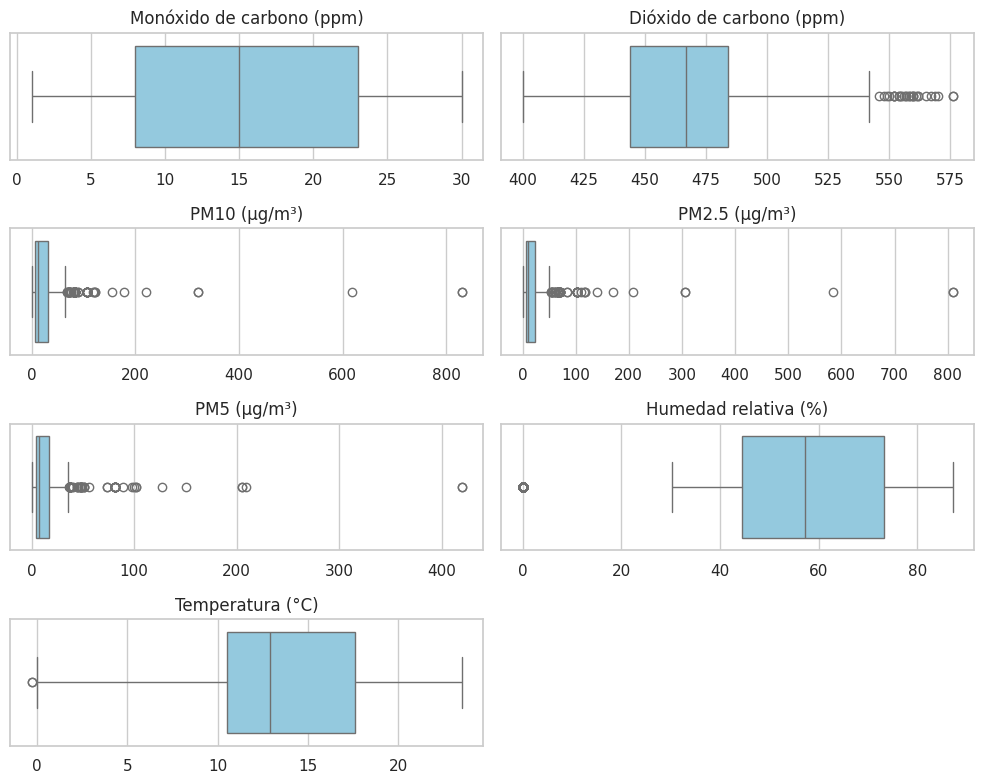

In [ ]:
# DIAGRAMA DE CAJAS
variables = [
    ('co', 'Monóxido de carbono (ppm)'),
    ('co2', 'Dióxido de carbono (ppm)'),
    ('pm10', 'PM10 (µg/m³)'),
    ('pm2_5', 'PM2.5 (µg/m³)'),
    ('pm5', 'PM5 (µg/m³)'),
    ('humedad_relativa', 'Humedad relativa (%)'),
    ('temperatura', 'Temperatura (°C)')
]

# Configuración
sns.set(style="whitegrid")
num_variables = len(variables)
columnas = 2
filas = (num_variables + columnas - 1) // columnas

# Crear subgráficos
fig, axes = plt.subplots(filas, columnas, figsize=(10, 2 * filas))
axes = axes.flatten()

# Crear los boxplots horizontales
for i, (columna, titulo) in enumerate(variables):
    sns.boxplot(data=aire, x=columna, ax=axes[i], color='skyblue', orient='h')
    axes[i].set_title(titulo)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Eliminar ejes vacíos si los hay
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



## Imputacion de Datos para variables Humedad relativa y temperatura

### Distribucion de datos Humedad y temperatura

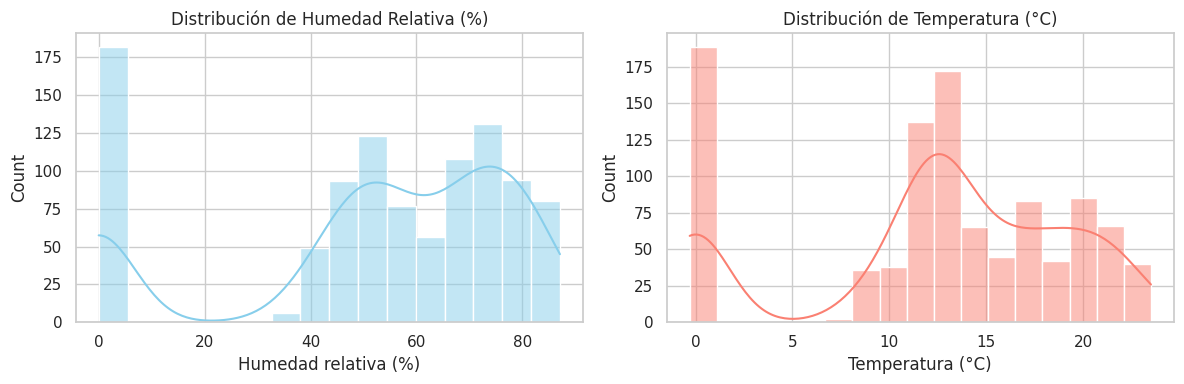

In [ ]:
# Estilo visual
sns.set(style="whitegrid")

# Crear subplots: una fila, dos columnas
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribución de la humedad relativa
sns.histplot(aire['humedad_relativa'], kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Distribución de Humedad Relativa (%)')
axes[0].set_xlabel('Humedad relativa (%)')

# Distribución de la temperatura
sns.histplot(aire['temperatura'], kde=True, color='salmon', ax=axes[1])
axes[1].set_title('Distribución de Temperatura (°C)')
axes[1].set_xlabel('Temperatura (°C)')

plt.tight_layout()
plt.show()


### Correccion variable Humedad relativa

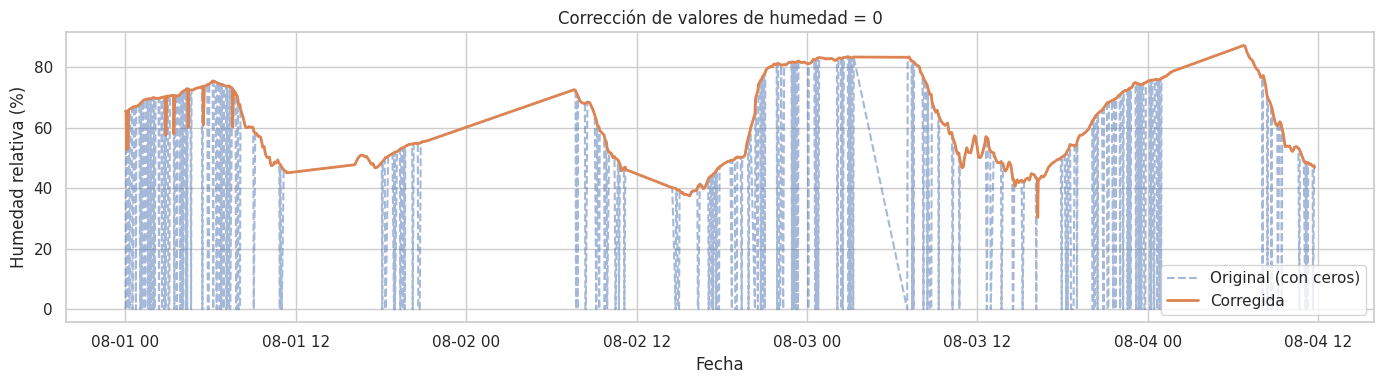

In [ ]:
humedad = aire['humedad_relativa'].copy()
humedad_corregida = humedad.copy()

i = 0
while i < len(humedad):
    if humedad[i] == 0:
        # Inicia un bloque de ceros
        inicio = i
        while i < len(humedad) and humedad[i] == 0:
            i += 1
        fin = i  # posición del primer valor no cero después del bloque

        # Obtener valor anterior no cero
        if inicio > 0:
            valor_anterior = humedad[inicio - 1]
        else:
            valor_anterior = np.nan  # inicio del vector

        # Obtener valor posterior no cero
        if fin < len(humedad):
            valor_posterior = humedad[fin]
        else:
            valor_posterior = np.nan  # final del vector

        # Imputar con el promedio si ambos valores existen
        if not np.isnan(valor_anterior) and not np.isnan(valor_posterior):
            promedio = (valor_anterior + valor_posterior) / 2
            humedad_corregida[inicio:fin] = promedio
        # Si solo uno de los dos existe, usar ese
        elif not np.isnan(valor_anterior):
            humedad_corregida[inicio:fin] = valor_anterior
        elif not np.isnan(valor_posterior):
            humedad_corregida[inicio:fin] = valor_posterior
        # Si ambos son NaN, deja como está

    else:
        i += 1

# Reemplazamos la columna original con la corregida
aire['humedad_relativa'] = humedad_corregida

# Graficar antes y después
plt.figure(figsize=(14, 4))
plt.plot(aire['fecha'], humedad, label='Original (con ceros)', linestyle='--', alpha=0.5)
plt.plot(aire['fecha'], humedad_corregida, label='Corregida', linewidth=2)
plt.xlabel('Fecha')
plt.ylabel('Humedad relativa (%)')
plt.title('Corrección de valores de humedad = 0')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Correccion variable temperatura

🌡️ Se corrigieron 182 valores de temperatura igual a cero.


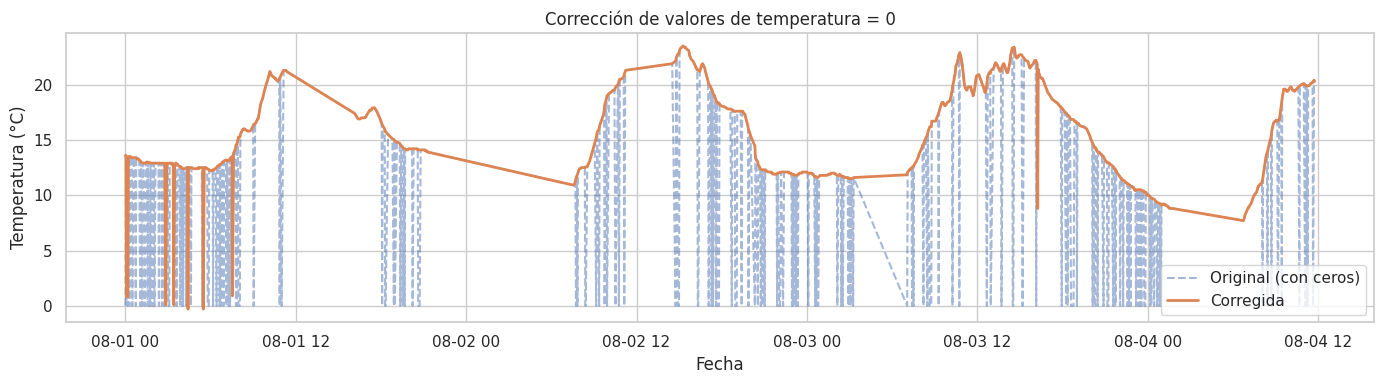

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Copiar la serie original
temperatura = aire['temperatura'].copy()
temperatura_corregida = temperatura.copy()

# Contador de valores corregidos
corregidos = 0

i = 0
while i < len(temperatura):
    if temperatura[i] == 0:
        # Inicia bloque de ceros
        inicio = i
        while i < len(temperatura) and temperatura[i] == 0:
            i += 1
        fin = i

        # Buscar valor anterior y posterior no cero
        valor_anterior = temperatura[inicio - 1] if inicio > 0 else np.nan
        valor_posterior = temperatura[fin] if fin < len(temperatura) else np.nan

        # Calcular valor de imputación
        if not np.isnan(valor_anterior) and not np.isnan(valor_posterior):
            promedio = (valor_anterior + valor_posterior) / 2
        elif not np.isnan(valor_anterior):
            promedio = valor_anterior
        elif not np.isnan(valor_posterior):
            promedio = valor_posterior
        else:
            promedio = 0  # No hay con qué imputar

        # Reemplazar en el bloque
        temperatura_corregida[inicio:fin] = promedio
        corregidos += (fin - inicio)

    else:
        i += 1

# Reemplazar columna original
aire['temperatura'] = temperatura_corregida

# Mostrar cantidad corregida
print(f"🌡️ Se corrigieron {corregidos} valores de temperatura igual a cero.")

# Graficar comparación
plt.figure(figsize=(14, 4))
plt.plot(aire['fecha'], temperatura, label='Original (con ceros)', linestyle='--', alpha=0.5)
plt.plot(aire['fecha'], temperatura_corregida, label='Corregida', linewidth=2)
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.title('Corrección de valores de temperatura = 0')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Conclusiones
* Aunque el comportamiento de los datos mejoro significativamente hay algunos datos que aun no concuerdan con el comportamiento de las dos variables. Sin embargo, para no volver tan sinteticos los datos, se procedera con el proyecto con esta unica imputaión.

## Matriz de dispersion para las variables numéricas

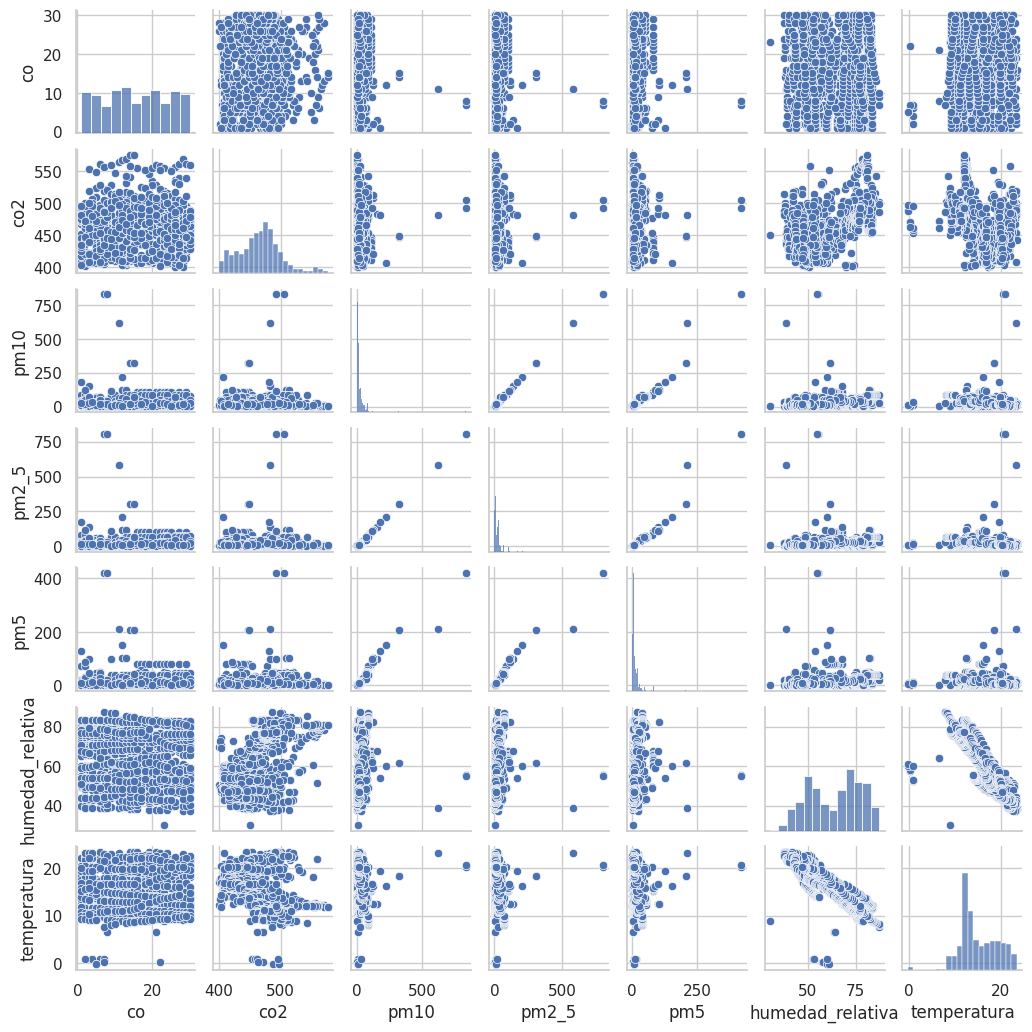

In [ ]:
aire_dispersion = aire.drop(columns=['fecha'])
sns.pairplot(aire_dispersion, height=1.5)  # Matriz de dispersion de todas las variables
plt.show()

### Conclusiones
* Se debe verificar si las condiciones de humedad y temperatura para f(x)=0 son correctas ya que pueden ser fallas de los sensores.

In [ ]:
# Cambiando el formato de la fecha para el modelo
aire['hora_decimal'] = (
    aire['fecha'].dt.hour +
    aire['fecha'].dt.minute / 60 +
    aire['fecha'].dt.second / 3600
)
aire.head(3)

,fecha,nombre_equipo,co,co2,pm10,pm2_5,pm5,humedad_relativa,temperatura,hora_decimal
0,2023-08-01 00:00:19,AirQualityUnit02,2,450,5,4,4,65.4,13.6,0.005278
1,2023-08-01 00:02:25,AirQualityUnit02,3,448,6,6,4,65.4,13.6,0.040278
2,2023-08-01 00:04:31,AirQualityUnit02,4,453,26,22,14,52.7,0.8,0.075278


# 2. Modelo Regresion para estimar el CO en funcion de los demas parametros

* Se analiza inicialmente la correlacion lineal de las variables para dar una aproximación de la efectividad del modelo y que variables tienden a ser las mas relevantes.

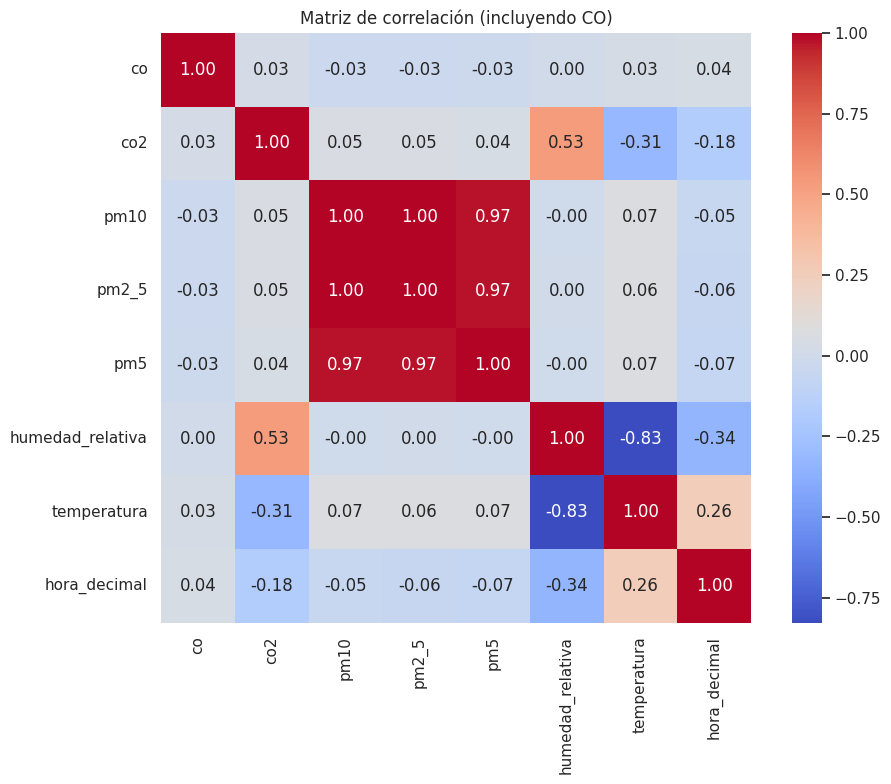

In [ ]:
# Matriz de correlación
data_matriz = aire.drop(columns=['fecha', 'nombre_equipo'])
matriz_corr = data_matriz.corr(method='pearson') #method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(matriz_corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de correlación (incluyendo CO)")
plt.tight_layout()
plt.show()

In [ ]:
# 1. Seleccionando los datos
X = aire.drop(columns=['co','fecha', 'nombre_equipo'])  # Eliminando columnas
y = aire['co']

In [ ]:
# 2. División 70% entrenamiento / 30% prueba
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(
    X, y, test_size=0.30, random_state=42)

In [ ]:
# 3. Escalamiento # StandarScaler Transforma los datos para que cada columna tenga media 0 y desviación estándar 1
escalador = StandardScaler()
X_entrenamiento = escalador.fit_transform(X_entrenamiento)
X_prueba = escalador.transform(X_prueba)

In [ ]:
# Entrenamiento del Modelo
modelo = models.Sequential()
modelo.add(layers.Dense(64, activation='relu', input_shape=(X_entrenamiento.shape[1],)))
modelo.add(layers.Dense(64, activation='relu'))
modelo.add(layers.Dense(64, activation='relu'))
modelo.add(layers.Dense(64, activation='relu'))
modelo.add(layers.Dense(1))  # Salida: valor de CO

modelo.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Entrenamiento
historial = modelo.fit(X_entrenamiento, y_entrenamiento, epochs=100, validation_data=(X_prueba, y_prueba), verbose=0)

# Mostrar errores del modelo
mae_entrenamiento = historial.history['mae']
mae_validacion = historial.history['val_mae']
loss_entrenamiento = historial.history['loss']  # MSE si usaste loss='mse'
loss_validacion = historial.history['val_loss']

print("MAE final entrenamiento:", mae_entrenamiento[-1])
print("MAE final validación:", mae_validacion[-1])
print("MSE final entrenamiento:", loss_entrenamiento[-1])
print("MSE final validación:", loss_validacion[-1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MAE final entrenamiento: 6.053477764129639
MAE final validación: 7.1864166259765625
MSE final entrenamiento: 53.814117431640625
MSE final validación: 74.24518585205078


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


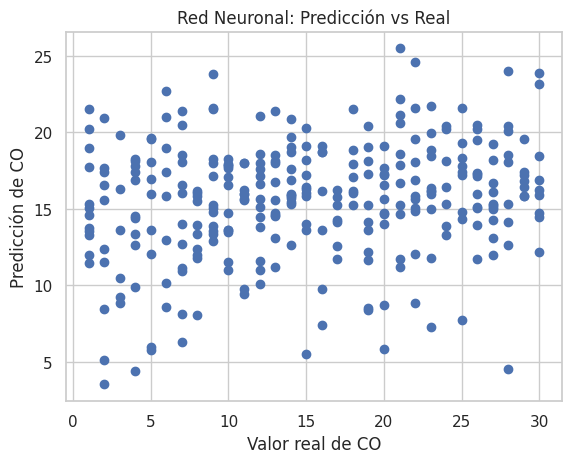

In [ ]:
predicciones = modelo.predict(X_prueba)

import matplotlib.pyplot as plt

plt.scatter(y_prueba, predicciones)
plt.xlabel("Valor real de CO")
plt.ylabel("Predicción de CO")
plt.title("Red Neuronal: Predicción vs Real")
plt.grid(True)
plt.show()


## Analizando otros optimizadores


🔧 Entrenando con: SGD
MAE final entrenamiento: 5.944210529327393
MAE final validación: 7.31919527053833
MSE final entrenamiento: 53.60799026489258
MSE final validación: 79.34992980957031

🔧 Entrenando con: RMSProp
MAE final entrenamiento: 6.41217565536499
MAE final validación: 7.044591426849365
MSE final entrenamiento: 59.124046325683594
MSE final validación: 71.80392456054688

🔧 Entrenando con: Adagrad
MAE final entrenamiento: 6.8179450035095215
MAE final validación: 7.258756637573242
MSE final entrenamiento: 63.92605972290039
MSE final validación: 71.89147186279297

🔧 Entrenando con: Adadelta
MAE final entrenamiento: 6.5079498291015625
MAE final validación: 7.303773403167725
MSE final entrenamiento: 60.68766784667969
MSE final validación: 75.57556915283203

🔧 Entrenando con: Adam
MAE final entrenamiento: 6.320187091827393
MAE final validación: 7.299553871154785
MSE final entrenamiento: 57.513553619384766
MSE final validación: 76.61739349365234

🔧 Entrenando con: Adamax
MAE final ent

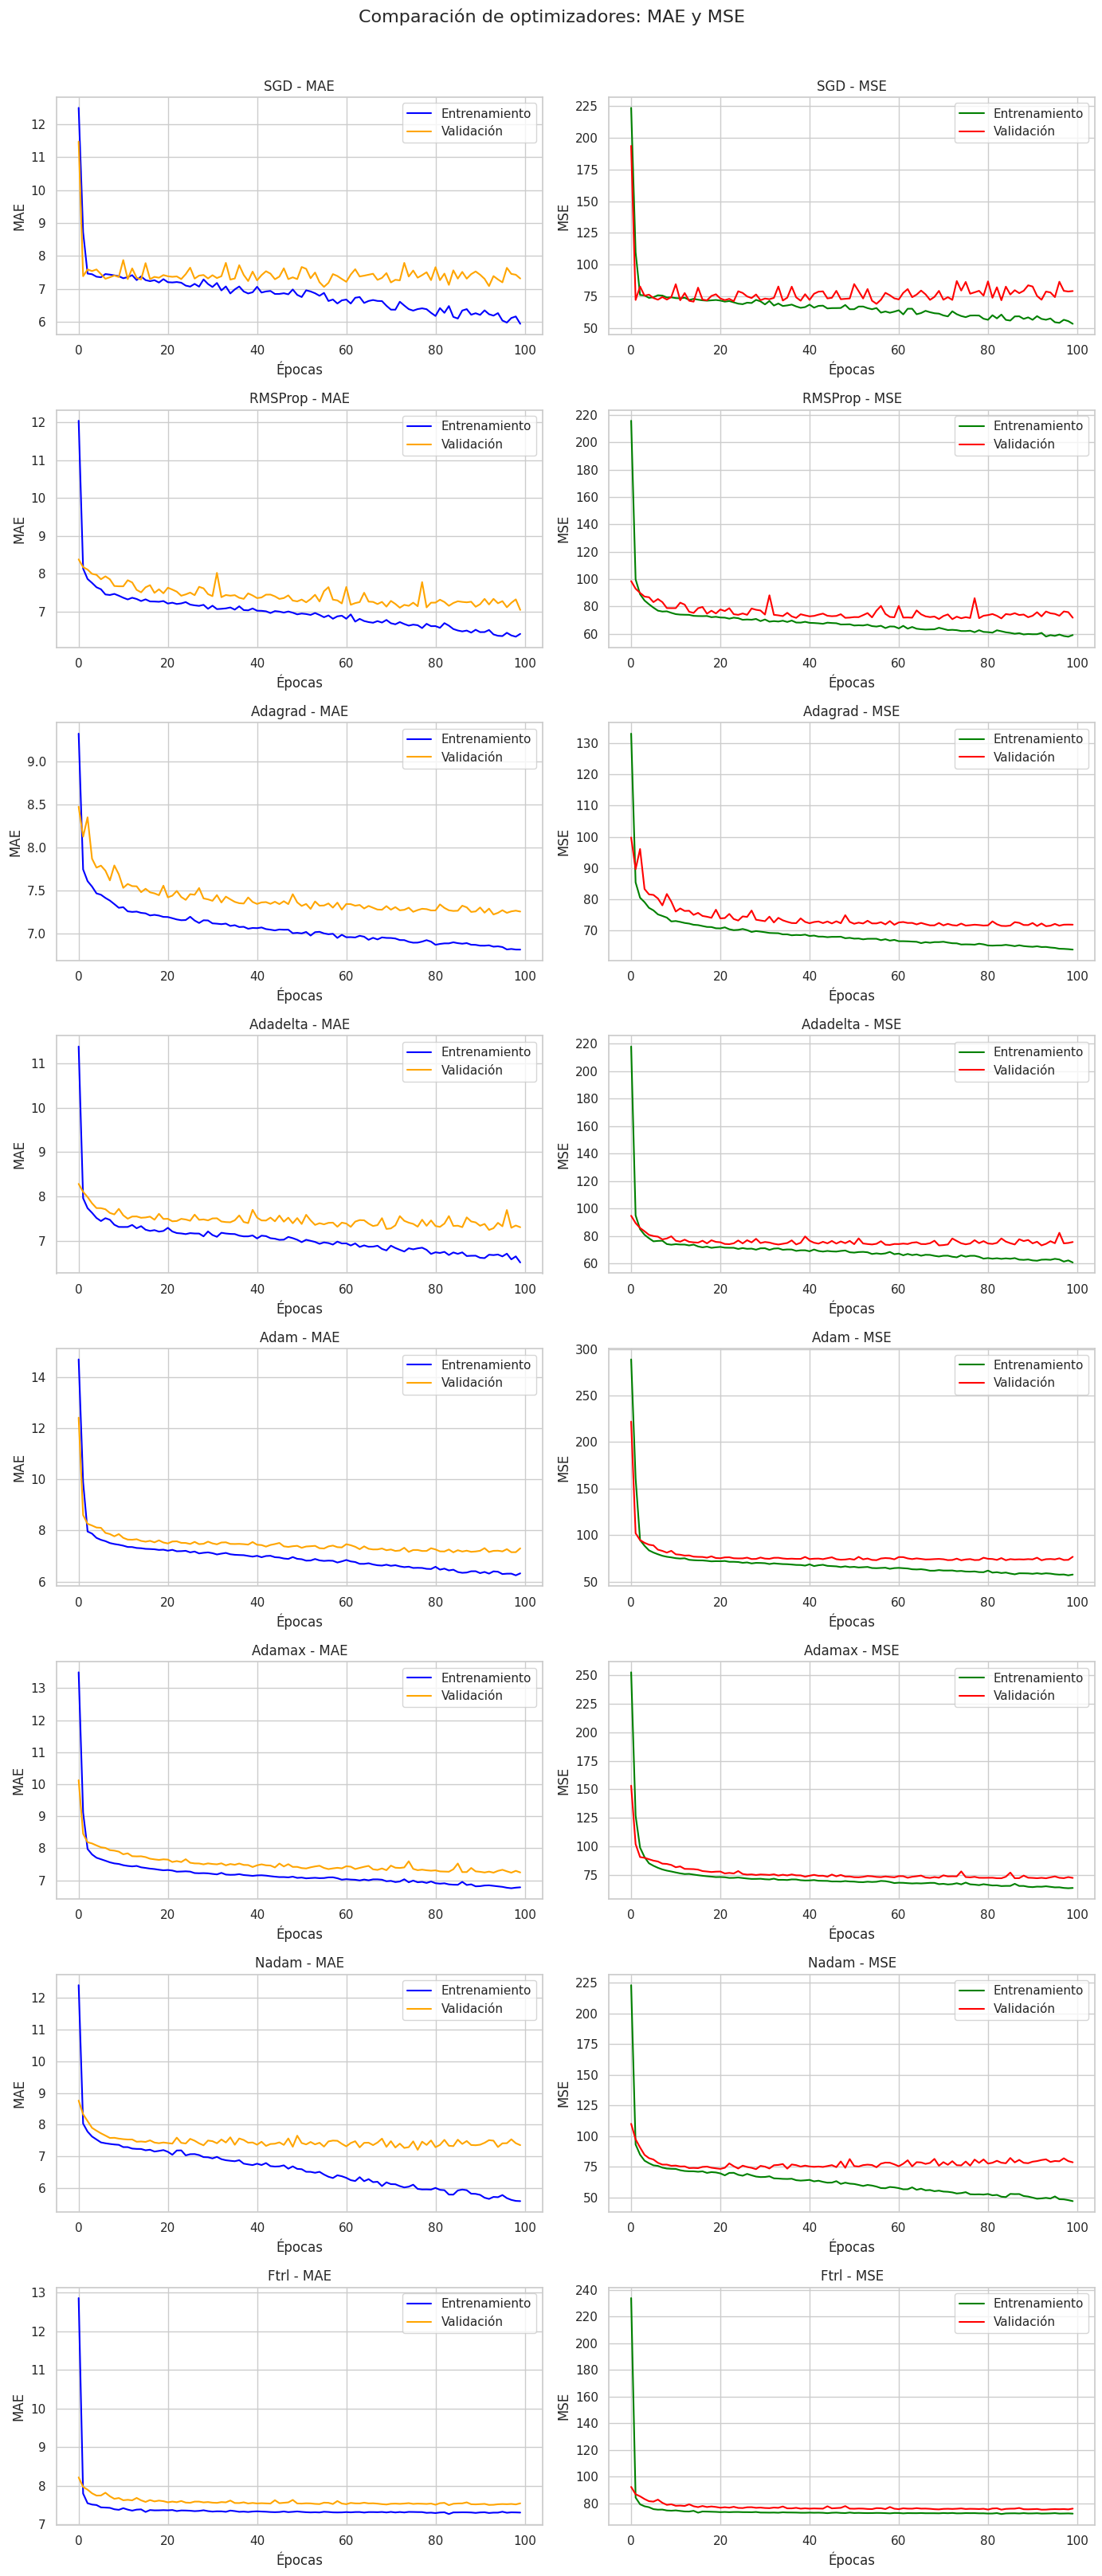

In [ ]:
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam, Ftrl
# Diccionario de optimizadores
optimizadores = {
    'SGD': SGD(learning_rate=0.01),
    'RMSProp': RMSprop(learning_rate=0.001),
    'Adagrad': Adagrad(learning_rate=0.01),
    'Adadelta': Adadelta(learning_rate=1.0),
    'Adam': Adam(learning_rate=0.001),
    'Adamax': Adamax(learning_rate=0.002),
    'Nadam': Nadam(learning_rate=0.002),
    'Ftrl': Ftrl(learning_rate=0.01)
}

# Preparar figura con 2 columnas y N filas
num_opt = len(optimizadores)
fig, axs = plt.subplots(nrows=num_opt, ncols=2, figsize=(14, 4 * num_opt))
fig.subplots_adjust(hspace=0.4)
fig.suptitle('Comparación de optimizadores: MAE y MSE', fontsize=16, y=1.01)

# Entrenar y graficar por cada optimizador
for i, (nombre, opt) in enumerate(optimizadores.items()):
    print(f"\n🔧 Entrenando con: {nombre}")

    # Red neuronal
    modelo = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(X_entrenamiento.shape[1],)),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    modelo.compile(optimizer=opt, loss='mse', metrics=['mae'])

    historial = modelo.fit(
        X_entrenamiento, y_entrenamiento,
        epochs=100,
        validation_data=(X_prueba, y_prueba),
        verbose=0
    )

    # Extraer métricas
    mae_entrenamiento = historial.history['mae']
    mae_validacion = historial.history['val_mae']
    mse_entrenamiento = historial.history['loss']
    mse_validacion = historial.history['val_loss']

    # Mostrar errores finales
    print("MAE final entrenamiento:", mae_entrenamiento[-1])
    print("MAE final validación:", mae_validacion[-1])
    print("MSE final entrenamiento:", mse_entrenamiento[-1])
    print("MSE final validación:", mse_validacion[-1])

    # 📊 Gráfica MAE
    axs[i, 0].plot(mae_entrenamiento, label='Entrenamiento', color='blue')
    axs[i, 0].plot(mae_validacion, label='Validación', color='orange')
    axs[i, 0].set_title(f"{nombre} - MAE")
    axs[i, 0].set_ylabel('MAE')
    axs[i, 0].set_xlabel('Épocas')
    axs[i, 0].legend()
    axs[i, 0].grid(True)

    # 📊 Gráfica MSE
    axs[i, 1].plot(mse_entrenamiento, label='Entrenamiento', color='green')
    axs[i, 1].plot(mse_validacion, label='Validación', color='red')
    axs[i, 1].set_title(f"{nombre} - MSE")
    axs[i, 1].set_ylabel('MSE')
    axs[i, 1].set_xlabel('Épocas')
    axs[i, 1].legend()
    axs[i, 1].grid(True)

plt.tight_layout()
plt.show()

## Conclusiones
* La prediccion de CO en funcion de las demas variables no es optima ya que no hay una correlacion clara entre las variables de entrada y las de salida.
* Se optará por predecir el pm 2.5 ya que tiene mayor correlación.

# Modelo de Regresion para estimar Material Particulado 2.5 (pm2.5) en funcion de los demas parámetros

In [ ]:
# 1. Seleccionando los datos
X_pm = aire.drop(columns=['pm2_5','fecha', 'nombre_equipo'])  # Eliminando columnas
y_pm = aire['pm2_5']

In [ ]:
# 2. División 70% entrenamiento / 30% prueba
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(
    X_pm, y_pm, test_size=0.30, random_state=42)

In [ ]:
# 3. Escalamiento # StandarScaler Transforma los datos para que cada columna tenga media 0 y desviación estándar 1
escalador = StandardScaler()
X_entrenamiento = escalador.fit_transform(X_entrenamiento)
X_prueba = escalador.transform(X_prueba)

In [ ]:
# Entrenamiento del Modelo
modelo = models.Sequential()
modelo.add(layers.Dense(64, activation='relu', input_shape=(X_entrenamiento.shape[1],)))
modelo.add(layers.Dense(64, activation='relu'))
modelo.add(layers.Dense(1))  # Salida: valor de CO

modelo.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Entrenamiento
historial = modelo.fit(X_entrenamiento, y_entrenamiento, epochs=100, validation_data=(X_prueba, y_prueba), verbose=1)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2904.2676 - mae: 20.4911 - val_loss: 580.8759 - val_mae: 15.6219
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3058.7522 - mae: 20.3455 - val_loss: 520.5283 - val_mae: 14.0113
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1938.1497 - mae: 16.6337 - val_loss: 437.9926 - val_mae: 12.3330
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1452.2445 - mae: 14.1481 - val_loss: 356.8097 - val_mae: 11.5267
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2683.7756 - mae: 16.0066 - val_loss: 290.0198 - val_mae: 11.5512
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2065.2395 - mae: 15.2722 - val_loss: 256.7081 - val_mae: 11.7341
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2138.8818 - mae: 15.2626 - val_loss: 233.9112 - val_mae: 11.8885
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1699.0989 - mae: 14.7591 - val_loss: 212.0470 - val_mae: 11.6516
Epoch 9/100
22/22 ━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


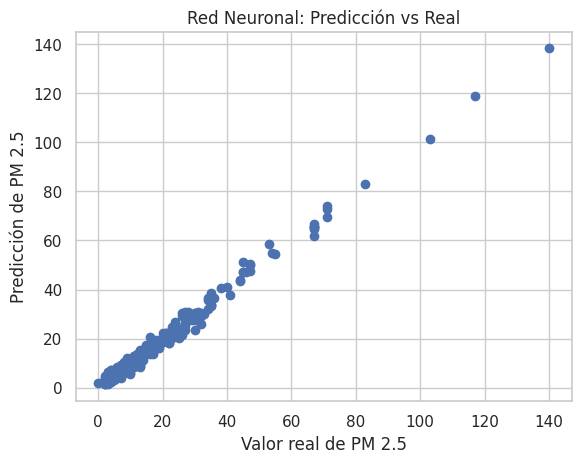

In [ ]:
# GRAFICANDO RESULTADOS
predicciones = modelo.predict(X_prueba)

import matplotlib.pyplot as plt

plt.scatter(y_prueba, predicciones)
plt.xlabel("Valor real de PM 2.5")
plt.ylabel("Predicción de PM 2.5")
plt.title("Red Neuronal: Predicción vs Real")
plt.grid(True)
plt.show()


# Estimacion de los demas parámetros

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


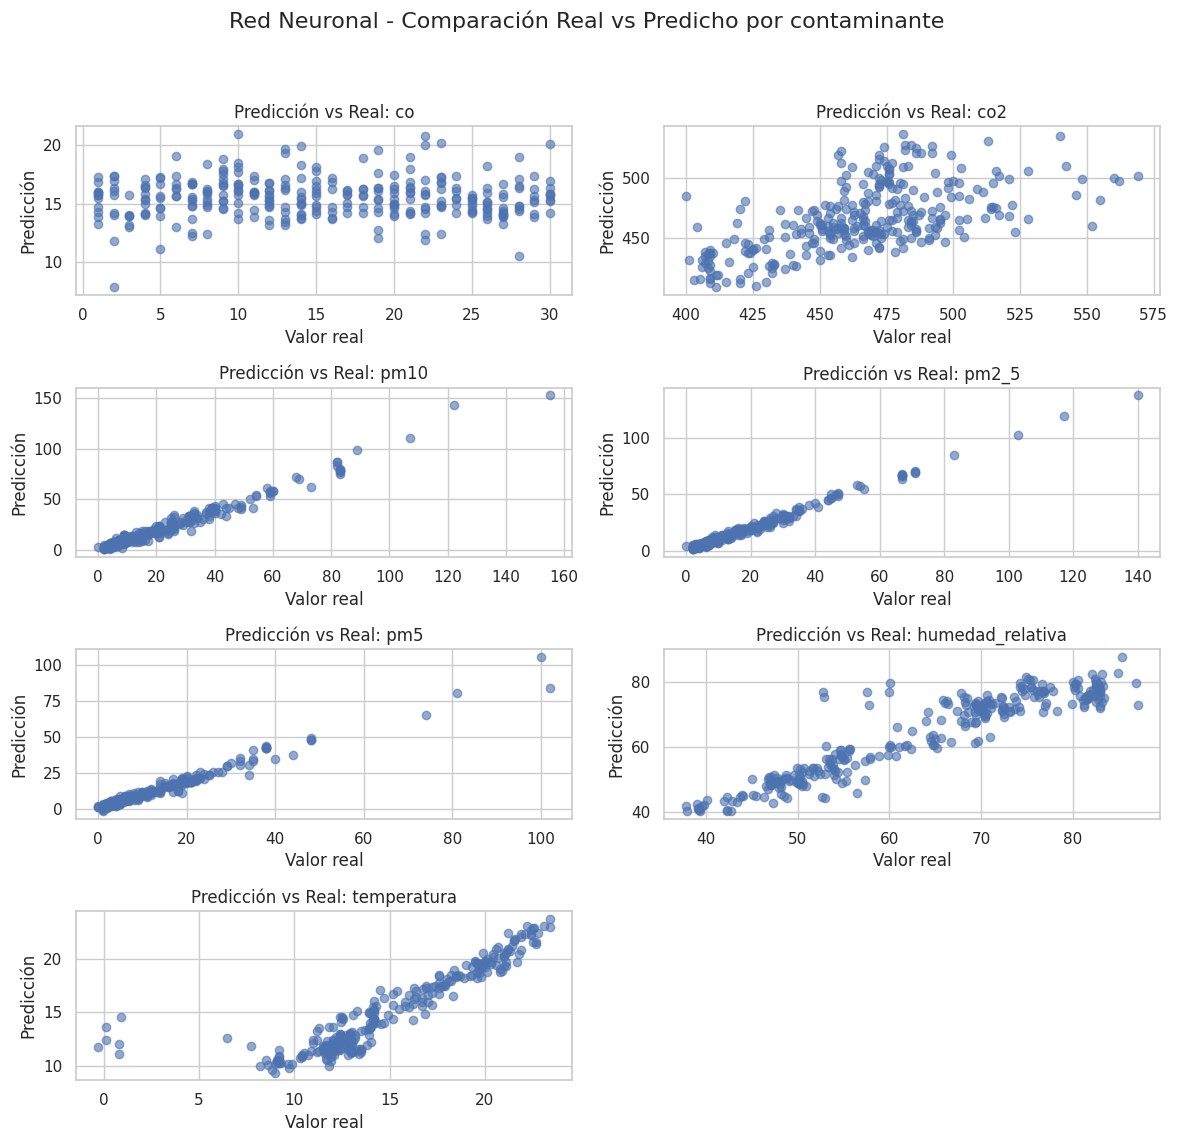

In [ ]:
# Lista de contaminantes como variables objetivo
contaminantes = ['co','co2', 'pm10', 'pm2_5', 'pm5', 'humedad_relativa', 'temperatura']

# matriz de subplots
filas = 4
columnas = 2
fig, axes = plt.subplots(filas, columnas, figsize=(12, 12))
axes = axes.flatten()  # Aplanar para indexar fácilmente

for i, contaminante in enumerate(contaminantes):
    #Preparar datos
    X = aire.drop(columns=[contaminante, 'fecha', 'nombre_equipo'])
    y = aire[contaminante]

    # División data entrenamiento - prueba
    X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(
        X, y, test_size=0.3, random_state=42)

    #Escalamiento
    escalador = StandardScaler()
    X_entrenamiento = escalador.fit_transform(X_entrenamiento)
    X_prueba = escalador.transform(X_prueba)

    #Modelo
    modelo = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(X_entrenamiento.shape[1],)),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    modelo.compile(optimizer='adam', loss='mse', metrics=['mae'])

     #Entrenamiento
    modelo.fit(X_entrenamiento, y_entrenamiento, epochs=100,
               validation_data=(X_prueba, y_prueba), verbose=0)
    predicciones = modelo.predict(X_prueba)

    #Gráfico
    axes[i].scatter(y_prueba, predicciones, alpha=0.6)
    axes[i].set_title(f"Predicción vs Real: {contaminante}")
    axes[i].set_xlabel("Valor real")
    axes[i].set_ylabel("Predicción")
    axes[i].grid(True)

# Se ocultan espacion si hay graficos vacios
if len(contaminantes) < len(axes):
    for j in range(len(contaminantes), len(axes)):
        fig.delaxes(axes[j])

fig.suptitle("Red Neuronal - Comparación Real vs Predicho por contaminante", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Conclusiones
* Algunas de las variables se pueden predecir con alta fiabilidad como pm(2.5, 5, 10), temperatura y humedad relativa aunque, estas ultimas dos, tienen al parecer valores atipicos en valores cercanos o iguales a cero como se habia planteado incialmente esto puede ocurrir por fallas en el sensor.